In [8]:
from qiskit import IBMQ, BasicAer, Aer
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, execute
import numpy as np

# 描画ツールのインポート
from qiskit.visualization import plot_histogram

n = 3  # 入力用量子ビット数

# ①作業ゲートを増やしてトフォリゲートで実装する場合はこっち
N = n + (n - 1) + 1  # 入力用量子ビット数 + 作業用量子ビット数 + 補助量子ビット

# ②マルチ制御トフォリゲートを使って実装する場合はこっち
# N = n + 1 #入力用量子ビット数 + 補助量子ビット

grover = QuantumCircuit(N, n)
ans = "101"  # 正解の値
iteration = 2

def cnx(n, N):
    if N == n + (n - 1) + 1:
        # ①作業ゲートを増やしてトフォリゲートで実装~~~~~~~~~~~~~~~~~~~~
        c = QuantumCircuit(N, n)
        c.barrier()
        c.ccx(0, 1, n)
        for i in range(n - 2):
            c.ccx(2 + i, n + i, n + 1 + i)

        c.cx(N - 2, N - 1)

        for i in range(n - 3, -1, -1):
            c.ccx(2 + i, n + i, n + 1 + i)
        c.ccx(0, 1, n)
        c.barrier()

        return c
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    else:
        # ②マルチ制御トフォリゲートを使って実装~~~~~~~~~~~~~~~~~~~~~~~
        c = QuantumCircuit(N, n)
        c.barrier()
        c.mct(list(range(N - 1)), N - 1)  # マルチ制御トフォリ
        c.barrier()

        return c


def cnz(n, N):  # 実質c(n-1)z

    if N == n + (n - 1) + 1:
        # ①作業ゲートを増やしてトフォリゲートで実装~~~~~~~~~~~~~~~~~~~~
        c = QuantumCircuit(N, n)
        c.barrier()
        c.ccx(0, 1, n)
        for i in range(n - 2):
            c.ccx(2 + i, n + i, n + 1 + i)

        # c.cx(N-2, N-1)
        c.z(N - 2)

        for i in range(n - 3, -1, -1):
            c.ccx(2 + i, n + i, n + 1 + i)
        c.ccx(0, 1, n)
        c.barrier()

        return c
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    else:
        # ②マルチ制御トフォリゲートを使って実装~~~~~~~~~~~~~~~~~~~~~~~
        c = QuantumCircuit(N, n)
        c.barrier()
        c.h(N - 2)
        c.mct(list(range(N - 2)), N - 2)  # マルチ制御トフォリ
        c.h(N - 2)
        c.barrier()

        return c
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


def oracle(n, N, ans):
    c_oracle = QuantumCircuit(N, n)
    c_oracle.barrier()

    for i in range(n):
        if ans[-i - 1] == "0":
            c_oracle.x(i)

    c_oracle += cnx(n, N)

    for i in range(n):
        if ans[i] == "0":
            c_oracle.x(n - i - 1)

    c_oracle.barrier()

    return c_oracle


def diffuser(n, N):
    c_diffuser = QuantumCircuit(N, n)

    for i in range(n):
        c_diffuser.h(i)

    for i in range(n):
        c_diffuser.x(i)

    c_diffuser += cnz(n, N)
    # 実はcnxゲートで良い
    # c_diffuser += cnx(n, N)

    for i in range(n):
        c_diffuser.x(i)

    for i in range(n):
        c_diffuser.h(i)

    return c_diffuser


# 入力用量子ビットを等確率化
for i in range(n):
    grover.h(i)

# 補助用量子ビットを(|0>-|1>)/√2に
grover.x(N - 1)
grover.h(N - 1)

for i in range(iteration):
    # オラクル(正解のビットにマイナスをつける)
    grover += oracle(n, N, ans)
    # 拡散（|0…0> -
    grover += diffuser(n, N)

# Measure
for i in range(n):
    grover.measure(i, i)

grover.draw()

┌───┐      ░       ░                           ░       ░ ┌───┐┌───┐ ░ »
q_0: ┤ H ├──────░───────░───■───────────────────■───░───────░─┤ H ├┤ X ├─░─»
     ├───┤      ░ ┌───┐ ░   │                   │   ░ ┌───┐ ░ ├───┤├───┤ ░ »
q_1: ┤ H ├──────░─┤ X ├─░───■───────────────────■───░─┤ X ├─░─┤ H ├┤ X ├─░─»
     ├───┤      ░ └───┘ ░   │                   │   ░ └───┘ ░ ├───┤├───┤ ░ »
q_2: ┤ H ├──────░───────░───┼────■─────────■────┼───░───────░─┤ H ├┤ X ├─░─»
     └───┘      ░       ░ ┌─┴─┐  │         │  ┌─┴─┐ ░       ░ └───┘└───┘ ░ »
q_3: ───────────░───────░─┤ X ├──■─────────■──┤ X ├─░───────░────────────░─»
                ░       ░ └───┘┌─┴─┐     ┌─┴─┐└───┘ ░       ░            ░ »
q_4: ───────────░───────░──────┤ X ├──■──┤ X ├──────░───────░────────────░─»
     ┌───┐┌───┐ ░       ░      └───┘┌─┴─┐└───┘      ░       ░            ░ »
q_5: ┤ X ├┤ H ├─░───────░───────────┤ X ├───────────░───────░────────────░─»
     └───┘└───┘ ░       ░           └───┘           ░       ░            ░ »
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«                               ░ ┌───┐┌───┐ ░       ░                     »
«q_0: ──■───────────────────■───░─┤ X ├┤ H ├─░───────░───■─────────────────»
«       │                   │   ░ ├───┤├───┤ ░ ┌───┐ ░   │                 »
«q_1: ──■───────────────────■───░─┤ X ├┤ H ├─░─┤ X ├─░───■─────────────────»
«       │                   │   ░ ├───┤├───┤ ░ └───┘ ░   │                 »
«q_2: ──┼────■─────────■────┼───░─┤ X ├┤ H ├─░───────░───┼────■─────────■──»
«     ┌─┴─┐  │         │  ┌─┴─┐ ░ └───┘└───┘ ░       ░ ┌─┴─┐  │         │  »
«q_3: ┤ X ├──■─────────■──┤ X ├─░────────────░───────░─┤ X ├──■─────────■──»
«     └───┘┌─┴─┐┌───┐┌─┴─┐└───┘ ░            ░       ░ └───┘┌─┴─┐     ┌─┴─┐»
«q_4: ─────┤ X ├┤ Z ├┤ X ├──────░────────────░───────░──────┤ X ├──■──┤ X ├»
«          └───┘└───┘└───┘      ░            ░       ░      └───┘┌─┴─┐└───┘»
«q_5: ──────────────────────────░────────────░───────░───────────┤ X ├─────»
«                               ░            ░       ░           └───┘     »
«c: 3/═════════════════════════════════════════════════════════════════════»
«                                                                          »
«           ░       ░ ┌───┐┌───┐ ░                           ░ ┌───┐┌───┐┌─┐   »
«q_0: ──■───░───────░─┤ H ├┤ X ├─░───■───────────────────■───░─┤ X ├┤ H ├┤M├───»
«       │   ░ ┌───┐ ░ ├───┤├───┤ ░   │                   │   ░ ├───┤├───┤└╥┘┌─┐»
«q_1: ──■───░─┤ X ├─░─┤ H ├┤ X ├─░───■───────────────────■───░─┤ X ├┤ H ├─╫─┤M├»
«       │   ░ └───┘ ░ ├───┤├───┤ ░   │                   │   ░ ├───┤├───┤ ║ └╥┘»
«q_2: ──┼───░───────░─┤ H ├┤ X ├─░───┼────■─────────■────┼───░─┤ X ├┤ H ├─╫──╫─»
«     ┌─┴─┐ ░       ░ └───┘└───┘ ░ ┌─┴─┐  │         │  ┌─┴─┐ ░ └───┘└───┘ ║  ║ »
«q_3: ┤ X ├─░───────░────────────░─┤ X ├──■─────────■──┤ X ├─░────────────╫──╫─»
«     └───┘ ░       ░            ░ └───┘┌─┴─┐┌───┐┌─┴─┐└───┘ ░            ║  ║ »
«q_4: ──────░───────░────────────░──────┤ X ├┤ Z ├┤ X ├──────░────────────╫──╫─»
«           ░       ░            ░      └───┘└───┘└───┘      ░            ║  ║ »
«q_5: ──────░───────░────────────░───────────────────────────░────────────╫──╫─»
«           ░       ░            ░                           ░            ║  ║ »
«c: 3/════════════════════════════════════════════════════════════════════╩══╩═»
«                                                                         0  1 »
«        
«q_0: ───
«        
«q_1: ───
«     ┌─┐
«q_2: ┤M├
«     └╥┘
«q_3: ─╫─
«      ║ 
«q_4: ─╫─
«      ║ 
«q_5: ─╫─
«      ║ 
«c: 3/═╩═
«      2

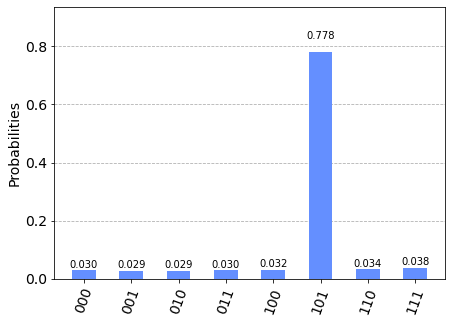

In [7]:
# 回路をシミュレーターに投げて結果を出力します
simulator = Aer.get_backend('qasm_simulator')
result = execute(grover, backend=simulator, shots=8192).result()

# 結果をヒストグラムでプロットします
plot_histogram(result.get_counts(grover))